In [144]:
import copy
import glob
import importlib
import itertools
import math
import os
import random
import shutil
import sys
from math import degrees, pi, radians
from os.path import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import SimpleITK as sitk
import skimage.feature as skf
from skimage.morphology import ball
import seaborn as sns
import cnn_builder as cbuild
import config
import lipiodol_analysis as lan
import lipiodol_methods as lm
import lipiodol_vis as lvis
import niftiutils.helper_fxns as hf
import niftiutils.masks as masks
import niftiutils.registration as reg
import niftiutils.transforms as tr
from config import Config
sns.set(style="ticks")
%matplotlib inline

In [77]:
importlib.reload(config)
C = config.Config()
target_dir = "D:\\Lipiodol\\Data"
lesions = [basename(fn) for fn in glob.glob(join(target_dir,"*"))]
num_lesions = len(lesions)
liplvls=[0,75,160,215]

In [495]:
pattern_df = pd.read_excel(C.data_xls_path, "Patterns")

In [89]:
def set_g_bar(g, save_path):
    g.set(yticks=[0.,.2,.4,.6,.8,1.], ylim=(0.,1.));
    """topbar = plt.Rectangle((0,0),1,1,fc="#C3C3C3", edgecolor = 'none')
    midbar = plt.Rectangle((0,0),1,1,fc='#A3A3A3',  edgecolor = 'none')
    bottombar = plt.Rectangle((0,0),1,1,fc='#737373',  edgecolor = 'none')
    l = plt.legend([bottombar, midbar, topbar],
                   ['High Lipiodol', 'Medium Lipiodol', 'Low Lipiodol'], loc='upper left')#, ncol=2, prop={'size':16})
    l.draw_frame(False)"""
    
    for gax in g.axes[0]:
        gax.set_xlabel("")
        gax.set_ylabel("")
        #gax.tick_params('x',width=0)
        gax.set_xticks([], minor=False)
        gax.set_yticks([], minor=False)
        plt.setp(gax.patches, linewidth=1, edgecolor='k')
        
    g.set_titles(visible=False)
    #g.axes[0][0].set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"]);
    
    sns.despine(top=True, right=True, left=True)
    g.fig.subplots_adjust(left=.2, top=.95)
    
    #g.fig.tight_layout(w_pad=1)
    #plt.setp(g.ax.lines,linewidth=1);
    g.fig.savefig(save_path, width=5, dpi=150, pad_inches=0, transparent=True)
    plt.close()

In [ ]:
def print_subset_stats(subset):
    print("%.1f%%+-%.1f%% (s.e.=%.1f%%)" % (np.mean(subset)*100,
                np.std(subset)*100, np.std(subset)*100/(len(subset)**.5)))

## Vascularization statistics

In [323]:
vasc_depo_df = pd.read_excel(C.data_xls_path, "Perfusion-Deposition Data")

In [341]:
def get_dvasc_df(vasc_depo_df, mode="density"):
    dvasc_df = copy.deepcopy(vasc_depo_df)
    if mode == "density":
        for l in ["N", "V", "A"]:
            dvasc_df["0"+l] = dvasc_df["0"+l] - dvasc_df["75"+l]
            dvasc_df["75"+l] = dvasc_df["75"+l] - dvasc_df["160"+l]
            dvasc_df["160"+l] = dvasc_df["160"+l] - dvasc_df["215"+l]
    elif mode == "V-N":
        dvasc_df["75dVN"] = dvasc_df["75V"] - dvasc_df["75N"]
    return dvasc_df

In [330]:
dvasc_df = get_dvasc_df(vasc_depo_df)

### Upper graph

In [82]:
for i in range(4):
    subset = (dvasc_df["%dV" % liplvls[i]] - dvasc_df["%dN" % liplvls[i]]).dropna()
    print("%.1f%%+-%.1f%% (s.e.=%.1f%%)" % (np.mean(subset)*100,
                                    np.std(subset)*100, np.std(subset)*100/(len(subset)**.5)))

#DV = dvasc_df.dropna()
#[scipy.stats.wilcoxon(DV["%dV" % liplvls[i]], DV["%dN" % liplvls[i]]) for i in range(4)]

for i in range(4):
    subset = dvasc_df[["%dV" % liplvls[i], "%dN" % liplvls[i]]].dropna()
    print(scipy.stats.wilcoxon(subset["%dV" % liplvls[i]], subset["%dN" % liplvls[i]]))

-0.047909277589692406 0.11751047183901932 0.01629577044690582
-0.06279384736115459 0.15106131524790584 0.02094843530251364
0.009425699200600697 0.09242838200911949 0.012817510409309755
0.10127742575024629 0.16765249490841708 0.023249217955837048
WilcoxonResult(statistic=404.0, pvalue=0.038078295820399954)
WilcoxonResult(statistic=343.0, pvalue=0.0016271628842539235)
WilcoxonResult(statistic=539.0, pvalue=0.46470209994046485)
WilcoxonResult(statistic=201.0, pvalue=0.00012237265715929783)


In [368]:
master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
#dvasc_df = dvasc_df.join(master_df, how='inner')
dvasc_df = vasc_depo_df.join(master_df, how='inner')
i=1
subset1 = dvasc_df.loc[dvasc_df["0=well delineated, 1=infiltrative"] == 0, "%dA" % liplvls[i]].dropna()
subset2 = dvasc_df.loc[dvasc_df["0=well delineated, 1=infiltrative"] == 1, "%dA" % liplvls[i]].dropna()
print(scipy.stats.mannwhitneyu(subset1, subset2).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)

0.0013432675407673645
76.8%+-26.1% (s.e.=4.0%)
53.9%+-25.5% (s.e.=6.6%)


In [104]:
kwargs = {"data":dvasc_df, "size":3, "aspect":.8, "kind":"bar", "color":"#C3C3C3", "legend":False}

In [107]:
g = sns.factorplot(x="0=well delineated, 1=infiltrative", y="75A", **kwargs)
set_g_bar(g, join(C.fig_dir, "Vascularization figures", "well-del vs infilt.png"))

In [369]:
i=1
subset1 = dvasc_df.loc[dvasc_df["selective=0"] == 0, "%dA" % liplvls[i]].dropna()
subset2 = dvasc_df.loc[dvasc_df["selective=0"] == 1, "%dA" % liplvls[i]].dropna()
print(scipy.stats.mannwhitneyu(subset1, subset2).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)

0.2555479867229442
70.0%+-28.7% (s.e.=4.8%)
72.4%+-26.3% (s.e.=5.6%)


In [110]:
g = sns.factorplot(x="selective=0", y="75A", **kwargs)
set_g_bar(g, join(C.fig_dir, "Vascularization figures", "selective vs lobar.png"))

In [370]:
i=1
subset1 = dvasc_df.loc[dvasc_df["HCC(0), ICC(1), other(2)"] == 0, "%dA" % liplvls[i]].dropna()
subset2 = dvasc_df.loc[dvasc_df["HCC(0), ICC(1), other(2)"] == 1, "%dA" % liplvls[i]].dropna()
subset3 = dvasc_df.loc[dvasc_df["HCC(0), ICC(1), other(2)"] == 2, "%dA" % liplvls[i]].dropna()
print(scipy.stats.kruskal(subset1, subset2, subset3).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)
print_subset_stats(subset3)

0.00011488191286503419
80.2%+-25.4% (s.e.=4.2%)
39.6%+-12.7% (s.e.=3.8%)
70.9%+-23.0% (s.e.=7.3%)


In [114]:
g = sns.factorplot(x="HCC(0), ICC(1), other(2)", y="75A", order=[0,2,1], **kwargs)
set_g_bar(g, join(C.fig_dir, "Vascularization figures", "tumor entity.png"))

In [116]:
g = sns.factorplot(x="0A", y="75A", , **kwargs)
set_g_bar(g, join(C.fig_dir, "Vascularization figures", "all tumors.png"))

### Middle Graph (Necro to Viable diff, no Lip breakdown)

In [342]:
Vdf = vasc_depo_df.dropna()
dvasc_df = get_dvasc_df(vasc_depo_df, "V-N")
master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
#master_df = master_df.join(pattern_df)
dvasc_df = dvasc_df.join(master_df)

In [366]:
i = 1
subset1 = dvasc_df.loc[dvasc_df["0=well delineated, 1=infiltrative"] == 0, "%ddVN" % liplvls[i]].dropna()
subset2 = dvasc_df.loc[dvasc_df["0=well delineated, 1=infiltrative"] == 1, "%ddVN" % liplvls[i]].dropna()
print("%.2f" % scipy.stats.mannwhitneyu(subset1, subset2).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)

2.72e-01
5.2%+-13.0% (s.e.=2.1%)
3.7%+-7.8% (s.e.=2.0%)


In [356]:
i = 1
subset1 = dvasc_df.loc[dvasc_df["selective=0"] == 0, "%ddVN" % liplvls[i]].dropna()
subset2 = dvasc_df.loc[dvasc_df["selective=0"] == 1, "%ddVN" % liplvls[i]].dropna()
print("%.2f" % scipy.stats.mannwhitneyu(subset1, subset2).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)

0.485
5.6%+-13.3% (s.e.=2.3%)
3.5%+-8.3% (s.e.=1.9%)


In [357]:
i = 1
subset1 = dvasc_df.loc[dvasc_df["HCC(0), ICC(1), other(2)"] == 0, "%ddVN" % liplvls[i]].dropna()
subset3 = dvasc_df.loc[dvasc_df["HCC(0), ICC(1), other(2)"] == 1, "%ddVN" % liplvls[i]].dropna()
subset2 = dvasc_df.loc[dvasc_df["HCC(0), ICC(1), other(2)"] == 2, "%ddVN" % liplvls[i]].dropna()
print("%.2f" % scipy.stats.kruskal(subset1, subset2, subset3).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)
print_subset_stats(subset3)

0.549
6.3%+-13.1% (s.e.=2.3%)
4.2%+-11.6% (s.e.=3.9%)
1.0%+-4.9% (s.e.=1.5%)


In [372]:
df = pd.DataFrame(columns=["Any Coverage", "Lesion_id", "Tissue Type",
                       "Tumor Growth", "Tumor Type", "TACE Type"])

master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
master_df = master_df.join(pattern_df)
modality = "mrbl"

In [373]:
importlib.reload(lvis)
ix = 0
for lesion_id, row in Vdf.iterrows():
    const = lvis.get_df_entry(lesion_id, master_df, modality)
    
    df.loc[ix] = [row["75N"], lesion_id, "Necrosis"] + const
    df.loc[ix+1] = [row["75V"], lesion_id, "Viable"] + const
    ix += 2

In [ ]:
def set_g_bar(g, save_path):
    g.set(yticks=[0.,.2,.4,.6,.8,1.], ylim=(0.,1.));
    
    for gax in g.axes[0]:
        gax.set_xlabel("")
        gax.set_ylabel("")
        #gax.tick_params('x',width=0)
        gax.set_xticks([], minor=False)
        gax.set_yticks([], minor=False)
        plt.setp(gax.patches, linewidth=1, edgecolor='k')
        
    g.set_titles(visible=False)
    #g.axes[0][0].set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"]);
    
    sns.despine(top=True, right=True, left=True)
    g.fig.subplots_adjust(left=.2, top=.95)
    
    #g.fig.tight_layout(w_pad=1)
    #plt.setp(g.ax.lines,linewidth=1);
    g.fig.savefig(save_path, width=5, dpi=150, pad_inches=0, transparent=True)
    plt.close()

In [376]:
kwargs = {"x":"Tissue Type", "data":df, "size":3, "aspect":.8, "kind":"bar", "legend":False}#, "ci":None

In [378]:
g1 = sns.factorplot(y="Any Coverage", color="#D3D3D3", **kwargs)
set_g_bar(g1, join(C.fig_dir, "Vascularization figures", "Mid graph", "Mean.png"))

for category, order in [("Tumor Growth", None), ("Tumor Type", None),
                        ("TACE Type", ["Selective", "Lobar"])]: #, ("Sparsity", ["Sparse", "Non"])
    order = lm.get_actual_order(category, df, order)
    g1 = sns.factorplot(y="Any Coverage", col=category, color="#D3D3D3", col_order=order, **kwargs)
    set_g_bar(g1, join(C.fig_dir, "Vascularization figures", "Mid graph", "%s.png" % category))

### Alternative Mid Graph (Lip density, no Necro/Viable separation)

In [332]:
Vdf = vasc_depo_df.dropna()

In [331]:
dvasc_df = get_dvasc_df(vasc_depo_df)

In [333]:
master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
#master_df = master_df.join(pattern_df)
dvasc_df = dvasc_df.join(master_df)

In [ ]:
for i in range(4):
    print(liplvls[i])
    subset1 = dvasc_df.loc[dvasc_df["0=well delineated, 1=infiltrative"] == 0, "%dA" % liplvls[i]].dropna()
    subset2 = dvasc_df.loc[dvasc_df["0=well delineated, 1=infiltrative"] == 1, "%dA" % liplvls[i]].dropna()
    print(scipy.stats.mannwhitneyu(subset1, subset2))
    print("%.1f%%+-%.1f%% (s.e.=%.1f%%)" % (np.mean(subset1)*100, np.std(subset1)*100, np.std(subset1)*100/(len(subset1)**.5)))
    print("%.1f%%+-%.1f%% (s.e.=%.1f%%)" % (np.mean(subset2)*100, np.std(subset2)*100, np.std(subset2)*100/(len(subset2)**.5)))

In [ ]:
for i in range(4):
    print(liplvls[i])
    subset1 = dvasc_df.loc[dvasc_df["selective=0"] == 0, "%dA" % liplvls[i]].dropna()
    subset2 = dvasc_df.loc[dvasc_df["selective=0"] == 1, "%dA" % liplvls[i]].dropna()
    print(scipy.stats.mannwhitneyu(subset1, subset2))
    print("%.1f%%+-%.1f%% (s.e.=%.1f%%)" % (np.mean(subset1)*100, np.std(subset1)*100, np.std(subset1)*100/(len(subset1)**.5)))
    print("%.1f%%+-%.1f%% (s.e.=%.1f%%)" % (np.mean(subset2)*100, np.std(subset2)*100, np.std(subset2)*100/(len(subset2)**.5)))

In [338]:
for i in range(4):
    subset1 = dvasc_df.loc[dvasc_df["HCC(0), ICC(1), other(2)"] == 0, "%dA" % liplvls[i]].dropna()
    subset3 = dvasc_df.loc[dvasc_df["HCC(0), ICC(1), other(2)"] == 1, "%dA" % liplvls[i]].dropna()
    subset2 = dvasc_df.loc[dvasc_df["HCC(0), ICC(1), other(2)"] == 2, "%dA" % liplvls[i]].dropna()
    print(scipy.stats.kruskal(subset1, subset2, subset3))
    print("%.1f%%+-%.1f%% (s.e.=%.1f%%)" % (np.mean(subset1)*100, np.std(subset1)*100, np.std(subset1)*100/(len(subset1)**.5)))
    print("%.1f%%+-%.1f%% (s.e.=%.1f%%)" % (np.mean(subset2)*100, np.std(subset2)*100, np.std(subset2)*100/(len(subset2)**.5)))
    print("%.1f%%+-%.1f%% (s.e.=%.1f%%)" % (np.mean(subset3)*100, np.std(subset3)*100, np.std(subset3)*100/(len(subset3)**.5)))

KruskalResult(statistic=18.14321160363808, pvalue=0.00011488191286503579)
19.8%+-25.4% (s.e.=4.2%)
29.1%+-23.0% (s.e.=7.3%)
60.4%+-12.7% (s.e.=3.8%)
KruskalResult(statistic=15.098642258431852, pvalue=0.0005264674091710209)
28.9%+-16.2% (s.e.=2.7%)
52.0%+-15.2% (s.e.=4.8%)
35.3%+-10.5% (s.e.=3.2%)
KruskalResult(statistic=16.318025146008512, pvalue=0.00028614480244862323)
16.4%+-10.6% (s.e.=1.7%)
12.7%+-10.4% (s.e.=3.3%)
3.0%+-3.4% (s.e.=1.0%)
KruskalResult(statistic=24.268648160106817, pvalue=5.371925862881901e-06)
34.9%+-27.5% (s.e.=4.5%)
6.3%+-5.9% (s.e.=1.9%)
1.3%+-2.0% (s.e.=0.6%)


In [316]:
def get_row(row):
    char="A"
    return [row["%d%s"%(liplvls[1],char)],
            row["%d%s"%(liplvls[1],char)] - row["%d%s"%(liplvls[3],char)],
            row["%d%s"%(liplvls[1],char)] - row["%d%s"%(liplvls[2],char)]]

In [317]:
df = pd.DataFrame(columns=["Any Coverage", "Low-Mid Coverage", "Low Coverage", "Lesion_id",
                       "Tumor Growth", "Tumor Type", "TACE Type"])

importlib.reload(lvis)
ix = 0
modality = "mrbl"
for lesion_id, row in Vdf.iterrows():
    const = lvis.get_df_entry(lesion_id, master_df, modality)
    
    df.loc[ix] = get_row(row) + [lesion_id] + const
    ix += 1

In [318]:
def set_g_bar(g, save_path):
    g.set(yticks=[0.,.2,.4,.6,.8,1.], ylim=(0.,1.));
    
    for gax in g.axes[0]:
        gax.set_xlabel("")
        gax.set_ylabel("")
        #gax.tick_params('x',width=0)
        gax.set_xticks([], minor=False)
        gax.set_yticks([], minor=False)
        plt.setp(gax.patches, linewidth=1, edgecolor='k')
        
    g.set_titles(visible=False)
    #g.axes[0][0].set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"]);
    
    sns.despine(top=True, right=True, left=True)
    g.fig.subplots_adjust(left=.2, top=.95)
    
    #g.fig.tight_layout(w_pad=1)
    #plt.setp(g.ax.lines,linewidth=1);
    g.fig.savefig(save_path, width=5, dpi=150, pad_inches=0, transparent=True)
    plt.close()

In [319]:
kwargs = {"data":df, "size":3, "aspect":.8, "kind":"bar", "ci":None, "legend":False}

In [320]:
g1 = sns.factorplot(y="Any Coverage", color="#D3D3D3", **kwargs)
set_g_bar(g1, join(C.fig_dir, "Vascularization figures", "Mid graph", "Mean1.png"))
g2 = sns.factorplot(y="Low-Mid Coverage", color="#939393", **kwargs)
set_g_bar(g2, join(C.fig_dir, "Vascularization figures", "Mid graph", "Mean2.png"))
g3 = sns.factorplot(y="Low Coverage", color="#333333", **kwargs)
set_g_bar(g3, join(C.fig_dir, "Vascularization figures", "Mid graph", "Mean3.png"))

for category, order in [("Tumor Growth", None), ("Tumor Type", None),
                        ("TACE Type", ["Selective", "Lobar"])]: #, ("Sparsity", ["Sparse", "Non"])

    order = lm.get_actual_order(category, df, order)
    g1 = sns.factorplot(y="Any Coverage", col=category, color="#D3D3D3", col_order=order, **kwargs)
    set_g_bar(g1, join(C.fig_dir, "Vascularization figures", "Mid graph", "%s1.png" % category))
    g2 = sns.factorplot(y="Low-Mid Coverage", col=category, color="#939393", col_order=order, **kwargs)
    set_g_bar(g2, join(C.fig_dir, "Vascularization figures", "Mid graph", "%s2.png" % category))
    g3 = sns.factorplot(y="Low Coverage", col=category, color="#333333", col_order=order, **kwargs)
    set_g_bar(g3, join(C.fig_dir, "Vascularization figures", "Mid graph", "%s3.png" % category))

## Response statistics

In [533]:
depo_resp_df = pd.read_excel(C.data_xls_path, "Deposition-Response Data")

In [534]:
Rdf = depo_resp_df.dropna()

In [381]:
scipy.stats.friedmanchisquare(*[Rdf[l] for l in liplvls])

FriedmanchisquareResult(statistic=23.937931034482745, pvalue=2.5736515175334642e-05)

In [387]:
scipy.stats.wilcoxon(Rdf[0], Rdf[160])

WilcoxonResult(statistic=83.0, pvalue=0.0036337564975753973)

In [139]:
dresp_df = copy.deepcopy(depo_resp_df)
dresp_df[215] = dresp_df[215] - dresp_df[0]
dresp_df[160] = dresp_df[160] - dresp_df[0]
dresp_df[75] = dresp_df[75] - dresp_df[0]
dresp_df[0] = 0

In [141]:
for l in liplvls:
    subset=dresp_df[l]
    print("%.1f%%+-%.1f%% (s.e.=%.1f%%)" % (np.mean(subset)*100, np.std(subset)*100, np.std(subset)*100/(len(subset)**.5)))

0.0%+-0.0% (s.e.=0.0%)
3.1%+-20.3% (s.e.=2.7%)
14.2%+-29.5% (s.e.=3.9%)
20.4%+-27.4% (s.e.=3.6%)


### Top graph

In [555]:
pattern_df = pd.read_excel(C.data_xls_path, "Patterns")
df = pd.DataFrame(columns=["Response", "Lesion_id", "Tumor Growth", "Tumor Type", "TACE Type", "Homogeneity", "Sparsity", "Rim Presence"])

master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
master_df = master_df.join(pattern_df)
modality = "ct24"
master_df["lipcoverage_vol"] = master_df["lipcoverage_vol"].astype(float)
master_df["high_lip"] = master_df["high_lip"].astype(float)
master_df["rim_lipiodol"] = master_df["rim_lipiodol"].astype(float)
master_df["low_peripheral"] = master_df["low_peripheral"].astype(float)
master_df["mid_peripheral"] = master_df["mid_peripheral"].astype(float)

In [557]:
importlib.reload(lvis)
ix = 0
for lesion_id, row in depo_resp_df.iterrows():
    const = lvis.get_df_entry(lesion_id, master_df, modality)
    df.loc[ix] = [row["Avg"], lesion_id] + const
    ix += 1
    
#df = df[df["Lesion_id"] != "BM-06"]
#df = df[df["Lesion_id"] != "BM-17"]

In [536]:
master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
#dvasc_df = dvasc_df.join(master_df, how='inner')
Rdf = depo_resp_df.join(master_df)
subset1 = Rdf.loc[Rdf["0=well delineated, 1=infiltrative"] == 0, "Avg"].dropna()
subset2 = Rdf.loc[Rdf["0=well delineated, 1=infiltrative"] == 1, "Avg"].dropna()
print(scipy.stats.mannwhitneyu(subset1, subset2).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)

0.10368857991512342
66.1%+-27.4% (s.e.=4.2%)
59.0%+-16.0% (s.e.=4.1%)


In [537]:
master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
#dvasc_df = dvasc_df.join(master_df, how='inner')
Rdf = depo_resp_df.join(master_df)
subset1 = Rdf.loc[Rdf["selective=0"] == 0, "Avg"].dropna()
subset2 = Rdf.loc[Rdf["selective=0"] == 1, "Avg"].dropna()
print(scipy.stats.mannwhitneyu(subset1, subset2).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)

0.20459844013535178
61.8%+-25.7% (s.e.=4.3%)
68.3%+-23.5% (s.e.=5.0%)


In [538]:
master_df = pd.read_excel(r"D:\Lipiodol\MASTER SOPHIE.xlsx", "Lesions analyzed", index_col="Lesion_ID")#"C:\Users\Clinton\Box\FOR CLINTON BOX FOLDER\MASTER SS SOPHIE.xlsx")
#dvasc_df = dvasc_df.join(master_df, how='inner')
Rdf = depo_resp_df.join(master_df)
subset1 = Rdf.loc[Rdf["HCC(0), ICC(1), other(2)"] == 0, "Avg"].dropna()
subset3 = Rdf.loc[Rdf["HCC(0), ICC(1), other(2)"] == 1, "Avg"].dropna()
subset2 = Rdf.loc[Rdf["HCC(0), ICC(1), other(2)"] == 2, "Avg"].dropna()
print(scipy.stats.kruskal(subset1, subset2, subset3).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)
print_subset_stats(subset3)

0.7353910426049588
65.0%+-27.8% (s.e.=4.6%)
66.3%+-23.4% (s.e.=7.4%)
59.9%+-14.5% (s.e.=4.4%)


In [559]:
importlib.reload(lan)
focal_df = df.dropna(subset=["Tumor Growth"])
focal_df = focal_df[focal_df["Tumor Growth"].str.contains("Focal")]

subdf = focal_df.dropna(subset=["Homogeneity"])
subset1 = subdf.loc[(subdf["Homogeneity"].str.contains("Homo")), "Response"]
subset2 = subdf.loc[(subdf["Homogeneity"].str.contains("Hetero")), "Response"]
print(scipy.stats.mannwhitneyu(subset1, subset2).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)

0.004311408088937038
88.5%+-14.4% (s.e.=5.1%)
61.5%+-27.3% (s.e.=4.7%)


In [560]:
subdf = focal_df.dropna(subset=["Rim Presence"])
subset1 = subdf.loc[(subdf["Rim Presence"].str.contains("Rim")), "Response"]
subset2 = subdf.loc[(subdf["Rim Presence"].str.contains("Non")), "Response"]
print(scipy.stats.mannwhitneyu(subset1, subset2).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)

0.3066801978727391
66.5%+-26.1% (s.e.=8.7%)
61.6%+-26.3% (s.e.=5.4%)


In [561]:
subdf = focal_df.dropna(subset=["Sparsity"])
subset1 = subdf.loc[subdf["Sparsity"].str.contains("Sparse"), "Response"]
subset2 = subdf.loc[subdf["Sparsity"].str.contains("Non"), "Response"]
print(scipy.stats.mannwhitneyu(subset1, subset2).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)

0.16932416584323556
56.0%+-26.7% (s.e.=7.4%)
64.9%+-27.0% (s.e.=5.9%)


In [562]:
importlib.reload(lan)
infil_df = df.dropna(subset=["Tumor Growth"])
infil_df = infil_df[infil_df["Tumor Growth"].str.contains("Infilt")]
subdf = infil_df.dropna(subset=["Sparsity"])
subset1 = subdf.loc[subdf["Sparsity"].str.contains("Sparse"), "Response"]
subset2 = subdf.loc[subdf["Sparsity"].str.contains("Non"), "Response"]
print(scipy.stats.mannwhitneyu(subset1, subset2).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)

0.3103089732188449
54.5%+-14.8% (s.e.=4.7%)
67.8%+-16.1% (s.e.=8.1%)


In [558]:
subdf = df.dropna(subset=["Sparsity"])
subset1 = subdf.loc[subdf["Sparsity"].str.contains("Sparse"), "Response"]
subset2 = subdf.loc[subdf["Sparsity"].str.contains("Non"), "Response"]
print(scipy.stats.mannwhitneyu(subset1, subset2).pvalue)
print_subset_stats(subset1)
print_subset_stats(subset2)

0.08337574999533126
55.3%+-22.4% (s.e.=4.7%)
65.4%+-25.6% (s.e.=5.1%)


In [430]:
#kwargs = {"x":"Lipiodol Deposition", "y":"Response", "data":df, "size":3, "markers":["s", "o", "^"], "legend":False}
kwargs = {"y":"Response", "data":df, "size":3, "kind":"bar", "legend":False}

def set_g_bar(g, save_path):
    g.set(yticks=[0.,.2,.4,.6,.8,1.], ylim=(0.,1.));
    
    for gax in g.axes[0]:
        gax.set_xlabel("")
        gax.set_ylabel("")
        #gax.tick_params('x',width=0)
        gax.set_xticks([], minor=False)
        gax.set_yticks([], minor=False)
        plt.setp(gax.patches, linewidth=1, edgecolor='k')
        
    g.set_titles(visible=False)
    #g.axes[0][0].set_yticklabels(["0%", "20%", "40%", "60%", "80%", "100%"]);
    
    sns.despine(top=True, right=True, left=True)
    g.fig.subplots_adjust(left=.2, top=.95)
    
    #g.fig.tight_layout(w_pad=1)
    #plt.setp(g.ax.lines,linewidth=1);
    g.fig.savefig(save_path, width=5, dpi=150, pad_inches=0, transparent=True)
    plt.close()

In [ ]:
for category, order in [("Tumor Growth", None), ("Tumor Type", None),
                        ("TACE Type", ["Selective", "Lobar"]), ("Sparsity", ["Sparse", "Non"])]:
    g = sns.factorplot(x=category, order=lm.get_actual_order(category, df, order), **kwargs)
    set_g_bar(g, join(C.fig_dir, "Deposition figures", "Top graph", "%s.png" % category));

In [523]:
importlib.reload(lan)
focal_df = df.dropna(subset=["Tumor Growth"])
focal_df = focal_df[focal_df["Tumor Growth"].str.contains("Focal")]
for ix, row in focal_df.iterrows():
    focal_df.loc[ix, "Tumor Type"] = lvis.check_column(row["Lesion_id"], master_df, "HCC(0), ICC(1), other(2)", 
                                                  {0: "HCCs", 1: "ICCs", 2: "Metastases"}, "Focal")
    focal_df.loc[ix, "Sparsity"] = lvis.check_sparse(row["Lesion_id"], master_df, modality, "Focal")
kwargs["data"] = focal_df

#for category, order in [("Sparsity", ["Sparse", "Non"]), ("Rim Presence", ["Rim", "Non"]), ("Homogeneity", ["Homo", "Hetero"])]:
#    g = sns.factorplot(x=category, order=lan.get_actual_order(category, focal_df, order), **kwargs)
#    set_g_bar(g, join(C.fig_dir, "Deposition figures", "Top graph", "Focal_%s.png" % category));
    
for category, order in [("Rim Presence", ["Rim", "Non"])]:
    g = sns.factorplot(x=category, order=lan.get_actual_order(category, focal_df, order), **kwargs)
    set_g_bar(g, join(C.fig_dir, "Deposition figures", "Top graph", "Focal_%s.png" % category));

In [526]:
infil_df = df.dropna(subset=["Tumor Growth"])
infil_df = infil_df[infil_df["Tumor Growth"].str.contains("Infiltrative")]
for ix, row in infil_df.iterrows():
    infil_df.loc[ix, "Tumor Type"] = lvis.check_column(row["Lesion_id"], master_df, "HCC(0), ICC(1), other(2)", 
                                                  {0: "HCCs", 1: "ICCs", 2: "Metastases"}, "Infiltrative")
    infil_df.loc[ix, "Sparsity"] = lvis.check_sparse(row["Lesion_id"], master_df, modality, "Infiltrative")
kwargs["data"] = infil_df

for category, order in [("Sparsity", ["Sparse", "Non"])]:
    g = sns.factorplot(x=category, order=lm.get_actual_order(category, infil_df, order), **kwargs)
    set_g_bar(g, join(C.fig_dir, "Deposition figures", "Top graph", "Infil_%s.png" % category));

## Prediction of Lipiodol deposition

In [ ]:
pattern_df = pd.read_excel(C.data_xls_path, "Patterns")

In [277]:
lesion_id, lesions.index(lesion_id)

('BM-09', 6)

In [5]:
cols = ["T_art", "DICE_art", "T_sub", "DICE_sub"]
T_df = pd.DataFrame(columns=cols)

In [ ]:
importlib.reload(lan)
for lesion_id in lesions[0:]:
    print(lesion_id)
    T_df.loc[lesion_id] = lan.get_best_T_lip(lesion_id, target_dir, liplvls[2])

In [380]:
T_df["DICE_art"].mean(), T_df["DICE_sub"].mean()

(0.8375604683744453, 0.832073280132539)

In [279]:
lesion_id = "BM-01"

In [379]:
T_df

,T_art,DICE_art,T_sub,DICE_sub
BM-01,62.0,0.643176,6.0,0.641502
BM-02,1985.0,0.907346,1524.0,0.914519
BM-03,212.0,0.833855,122.0,0.833855
BM-04B,391.0,0.722067,258.0,0.722067
BM-06,147.0,0.583491,94.0,0.564450
BM-07,129.0,0.681140,44.0,0.675962
BM-09,1471.0,0.828688,1376.0,0.794967
BM-10,3460.0,0.764697,1921.0,0.701265
BM-12,989.0,0.738695,301.0,0.741802
BM-13,424.0,0.948086,284.0,0.948071


In [280]:
T_df.loc[lesion_id]

T_art       49.000000
DICE_art     0.887319
T_sub        6.000000
DICE_sub     0.887319
Name: BM-01, dtype: float64

In [237]:
P = lm.get_paths_dict(lesion_id, target_dir)

In [266]:
art.min()

1.0765673585060012

In [263]:
art = hf.nii_load(P['ct24Tx']['mrbl']['art'])[0]

244.51580895122024

In [275]:
art[M != 0].min()

49.0412244737328

In [268]:
img = masks.crop_img_to_mask_vicinity(P['ct24Tx']['mrbl']['art'], P['ct24Tx']['crop']['tumor'])

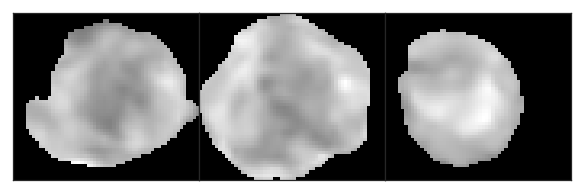

In [271]:
img = masks.draw_mask(P['ct24Tx']['crop']['tumor'], P['ct24Tx']['mrbl']['art']);

In [273]:
img.min()

0.0

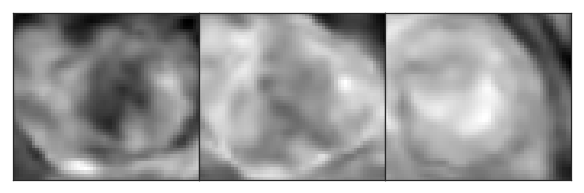

In [242]:
hf.draw_slices(img)

In [238]:
ct = hf.nii_load(P['ct24Tx']['crop']['img'])[0]
M = masks.get_mask(P['ct24Tx']['crop']['tumor'])[0]
ct[M != 0] = np.nan
ct_U = ct >= T_lip
ct_L = ct < T_lip
art = hf.nii_load(P['ct24Tx']['mrbl']['art'])[0].astype(int)
sub = hf.nii_load(P['ct24Tx']['mrbl']['sub'])[0].astype(int)

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.
C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


In [ ]:
M.sum()/M.max()

In [ ]:
ct[M != 0] = np.nan

In [200]:
(~np.isnan(ct)).sum()

54287

In [193]:
(ct < 99999).sum()

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


54287

In [202]:
T_df

,T_art,DICE_art,T_sub,DICE_sub
BM-01,1.0,0.887319,-47.0,0.887319
BM-02,2802.0,4.106063,2302.0,4.106063
BM-03,115.0,3.995429,259.0,3.990032
BM-04B,174.0,8.365082,295.0,7.144821
BM-06,385.0,4.885093,311.0,4.885093
BM-07,74.0,3.096933,5.0,3.093746


In [161]:
lm.reg_to_ct24(lesion_id, target_dir)

In [204]:
lesion_id

'PK-03B'